In [198]:
# TEST: This hopefully shows on Colab!
# EXECUTING THE FOLLOWING WILL INSTALL GLOBAL DEPENDENCIES ON YOUR SYSTEM.
# ONLY RUN FOR GOOGLE COLAB INSTANCES, ETC.
# Installs Pyomo (modeling language) and IPOPT (solver). See http://www.pyomo.org/ and https://coin-or.github.io/Ipopt/.

# !pip install pyomo
# !wget -N -q "https://matematica.unipv.it/gualandi/solvers/ipopt-linux64.zip"
# !unzip -o -q ipopt-linux64

from pyomo.environ import (
    SolverFactory,
    AbstractModel,
    Param,
    RangeSet,
    Var,
    Objective,
    Constraint,
)
from pyomo.core import NonNegativeIntegers, PositiveReals, NonNegativeReals  # type: ignore

# from utils import get_mean

import matplotlib.pyplot as plt
import pandas as pd

solver = SolverFactory("mindtpy")

### Reservoir Stats

- Name: Curve Reservoir
- Coordinates: $36.33385606273248, -111.6578894846542$
- Perimeter: $699.69$ m
- Area: $19,991.22$ m^2
- Elevation: $1,815$ m


In [199]:
# TODO: Change t to k, fix mutability warnings
mu = 1e-6

model = AbstractModel()

# Set `K` of period indices
model.num_periods = Param(within=NonNegativeIntegers)
model.T_periods = RangeSet(0, model.num_periods - 1)
model.T_points = RangeSet(0, model.num_periods)

# Constant parameters
model.c1 = Param(within=PositiveReals)  # Scalar constant c1 for volume
model.c2 = Param(within=PositiveReals)  # Scalar constant c2 for volume
model.A_c = Param(within=PositiveReals)  # Catchment area
model.A_max = Param(within=PositiveReals)  # Maximum surface area
model.Q_max = Param(within=NonNegativeReals)  # Maximum pumping rate
model.E_coeff = Param(within=PositiveReals)  # Evaporation coefficient

# Time-varying parameters
model.P = Param(model.T_periods, within=NonNegativeReals)  # Precipitation rate
model.E_pan = Param(model.T_periods, within=NonNegativeReals)  # Pan evaporation rate

# Time-invariant parameters
model.S_max = Param(
    initialize=model.c1 * (mu + model.A_max) ** model.c2
)  # Maximum storage capacity
model.R = Param(
    model.T_periods,
    default=lambda model, t: model.A_c * model.P[t],
    within=NonNegativeReals,
)  # Calculate rainfall [6]

# Optimizable variables
model.V = Var(model.T_points, domain=NonNegativeReals)  # Volume
model.S = Var(model.T_points, domain=NonNegativeReals)  # Storage
model.A = Var(model.T_points, domain=NonNegativeReals)  # Surface area
model.E = Var(model.T_periods, domain=NonNegativeReals)  # Evaporation
model.Q = Var(model.T_periods, domain=NonNegativeReals)  # Pumping
model.W = Var(model.T_periods, domain=NonNegativeReals)  # Overflow

# Objective
# model.min_overflow = Objective(
#     expr=lambda model: sum(model.W[t] for t in model.T_periods)
# )
model.trivial = Objective(expr=lambda _: 0)  # TEMPORARY: To verify model feasibility

# Constraints
model.volume = Constraint(
    model.T_periods,
    rule=lambda model, t: model.V[t + 1] == model.S[t] + model.R[t] - model.E[t] - model.Q[t],
)  # Volumetric balance equation [1]

model.overflow = Constraint(
    model.T_periods,
    rule=lambda model, t: model.W[t] == model.V[t] - model.S_max,
)  # Calculate overflow [2]

model.evaporation = Constraint(
    model.T_periods,
    rule=lambda model, t: model.E[t]
    == (model.A[t] + model.A[t + 1]) / 2 * model.E_coeff * model.E_pan[t],
)  # Calculate evaporation [7]

model.storage = Constraint(
    model.T_periods,
    rule=lambda model, t: model.S[t + 1] == model.V[t + 1] - model.W[t],
)  # Bound storage [3]

model.storage_to_area = Constraint(
    model.T_points,
    rule=lambda model, t: model.S[t] == model.c1 * (mu + model.A[t]) ** model.c2,
)  # Relate storage to area [4]

model.upper_A = Constraint(
    model.T_points, rule=lambda model, t: model.A[t] <= model.A_max
)  # Bound surface area [5]

model.upper_Q = Constraint(
    model.T_periods, rule=lambda model, t: model.Q[t] <= model.Q_max
)  # Bound pumping [8]

In [200]:
# Obtain average monthly precipitation (mm/hour)
# pga_df = pd.read_csv(
#     "Water Optimization/dynamics_model/PGA_1973_2005.csv",
#     usecols=["valid", "p01i"],
#     header=0,
#     dtype={
#         "valid": "string",  # Datetime. Consider "datetime64[ns, UTC]"
#         "p01i": "Float32",  # Precipitation in last hr (mm)
#     },
# )

# pga_df["valid"] = pd.to_datetime(pga_df["valid"], utc=True).dt.tz_localize(
#     None
# )  # Remove timezone information
# pga_df = pga_df.convert_dtypes()
# pga_df = pga_df.dropna()

# PRECIP_RATE = get_mean(pga_df, "valid", ["p01i"], "M").groupby(["month"]).mean()["p01i"]
PRECIP_RATE = [0.55, 0.51, 0.59, 0.28, 0.31, 0.16, 0.67, 0.71, 0.98, 0.87, 0.43, 0.31]
PRECIP_RATE = [r * 2.54 / 100 for r in PRECIP_RATE]

# Pan evporation rate (in/month)
pan_m_df = pd.DataFrame(
    {
        "month": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        "evap": [
            0.00,
            2.60,
            5.84,
            8.27,
            10.72,
            12.86,
            13.06,
            11.38,
            8.42,
            5.13,
            2.29,
            0.00,
        ],
    }
)

ELEVATION = 1815  # (m)
LATITUDE = 36.33385606273248

PAN_COEFF = 0.8
PAN_EVAP_RATE = (0.0254 * pan_m_df["evap"]).to_list()  # in/month -> m/month (m)

C1, C2 = (
    1.4534,
    1.1919,
)  # 30.684, 0.978  # Lehner, et al. (Global reservoir and dam database)
CATCHMENT_AREA = 10000  # 19991.22  # (m^2), from loading GEOJSON to http://geojson.io/
MAX_SURFACE_AREA = 100  # 482970.15  # (m^2)

In [201]:
# ALL AREAL AND VOLUMETRIC PARAMETERS ARE IN METERS (M), TEMPORAL UNIT IS MONTHS

data = {
    None: {
        "num_periods": {None: 12},
        "c1": {None: C1},
        "c2": {None: C2},
        "A_c": {None: CATCHMENT_AREA},
        "A_max": {None: MAX_SURFACE_AREA},
        "Q_max": {None: 0},
        "P": dict(enumerate(PRECIP_RATE)),
        "E_pan": dict(enumerate(PAN_EVAP_RATE)),
        "E_coeff": {None: PAN_COEFF},
    }
}

instance = model.create_instance(data)
results = solver.solve(instance)
# instance.pprint()

    or mutable Param).  The linkage between this RangeSet and the original
    source data will be broken, so updating the data value in the future will
    not be reflected in this RangeSet.  To suppress this warning, explicitly
    convert the source data to a constant type (e.g., float, int, or immutable
    Param)
    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Ipopt 3.14.12\x3a Converged to a locally
        infeasible point. Problem may be infeasible.


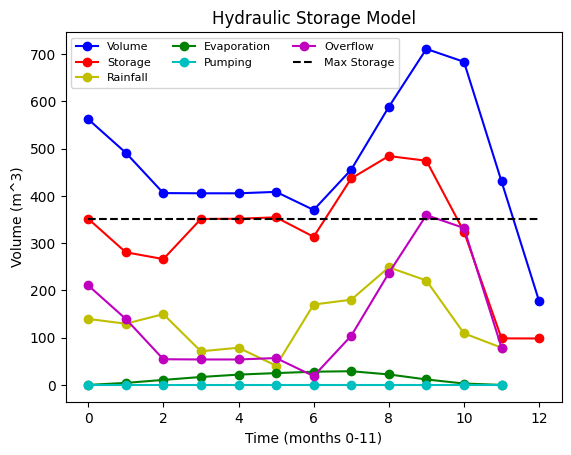

In [202]:
res_volume = [instance.V[i].value for i in instance.T_points]
res_storage = [instance.S[i].value for i in instance.T_points]
res_rainfall = [instance.R[i] for i in instance.T_periods]
res_evaporation = [instance.E[i].value for i in instance.T_periods]
res_pumping = [instance.Q[i].value for i in instance.T_periods]
res_overflow = [instance.W[i].value for i in instance.T_periods]

plt.title("Hydraulic Storage Model")
plt.plot(res_volume, "-bo", label="Volume")
plt.plot(res_storage, "-ro", label="Storage")
plt.plot(res_rainfall, "-yo", label="Rainfall")
plt.plot(res_evaporation, "-go", label="Evaporation")
plt.plot(res_pumping, "-co", label="Pumping")
plt.plot(res_overflow, "-mo", label="Overflow")
plt.hlines(
    y=instance.S_max.value,
    xmin=0,
    xmax=instance.num_periods,
    colors="k",
    linestyles="dashed",
    label="Max Storage",
)
plt.xlabel("Time (months 0-11)")
plt.ylabel("Volume (m^3)")
plt.legend(prop={"size": 8}, ncol=3)
plt.show()